# Anomaly Detection algs

## Imports and preprocessing

In [1]:
import pandas as pd

import Reader
import LogKeysManager
import ParamsExtractor
import DataPreprocessor
import ReduceDim
import ClusterData
import OneClass
import DetectAnomaly

2024-05-28 10:05:41.021265: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 10:05:41.021973: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 10:05:41.026862: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 10:05:41.072540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 10:05:41.891919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
# Testing Params Extractor
#log_types = ['cron', 'user']
log_types = ['cron', 'laurel', 'maillog', 'messages', 'secure', 'user']
file_paths = ['../../../temp_logs/login01.' + logtype + '.log' for logtype in log_types]

df_list = []

for file_path in file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file()
    df_list.append(df)

In [3]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)

for i in range(len(df_list)):
    #print('=================')
    #print(df_list[i].head())
    #print(df_list[i].columns)
    #print(df_list[i].iloc[0])
    #print('********')
    #print(df_after[i].head())
    #print(df_after[i].columns)
    #print(df_after[i].iloc[0])
    
    # Concatenate df and df_after
    df_list[i] = pd.concat([df_list[i], df_after[i]], axis=1)
    #print(df_list[i].columns)

In [4]:
# Data Preprcessor

for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_one_hot_encode()
    df_list[i] = enc

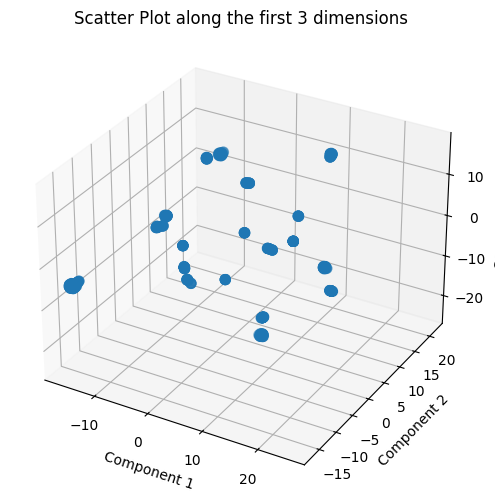

In [5]:
r = ReduceDim.ReduceDim(3, df_list[0], [1, 0])
umap_reduced_data = r.umap()

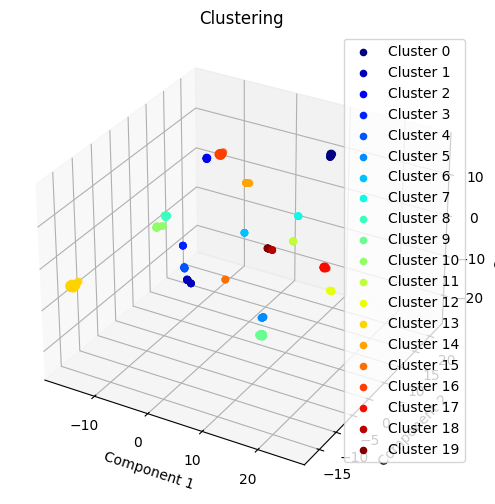

In [6]:
c = ClusterData.ClusterData(umap_reduced_data, plots=[1,0])
labels = c.dbscan()

## An Det

### Isolation Forest

In [7]:
umap_reduced_data

array([[ 12.980927 ,  12.974838 ,  16.323793 ],
       [ 13.01247  ,  12.959418 ,  16.334803 ],
       [ 13.023808 ,  13.269376 ,  16.69056  ],
       ...,
       [-12.244116 ,  20.869316 ,   2.7821002],
       [  4.453306 ,  -4.0652742,  -4.3325276],
       [  5.6534605,   4.1188226, -23.923248 ]], dtype=float32)

In [8]:
import numpy as np

In [9]:
# creation of artificial anomaly data point
point = [20,20,20]
new_data = np.vstack((point, umap_reduced_data))

In [10]:
d = DetectAnomaly.DetectAnomaly(umap_reduced_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

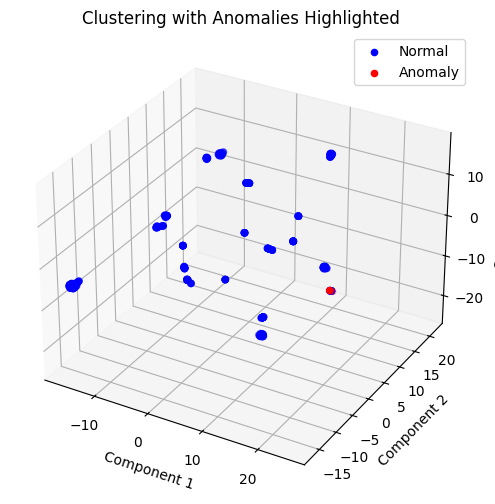

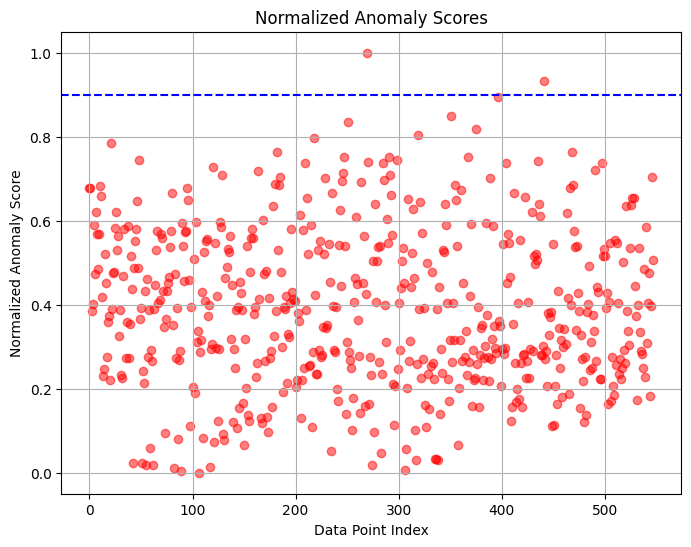

In [11]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

In [12]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

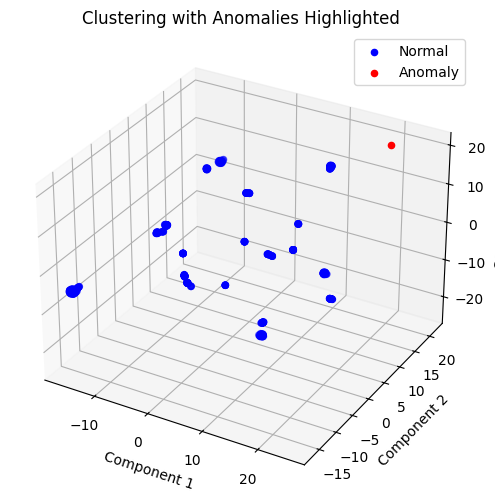

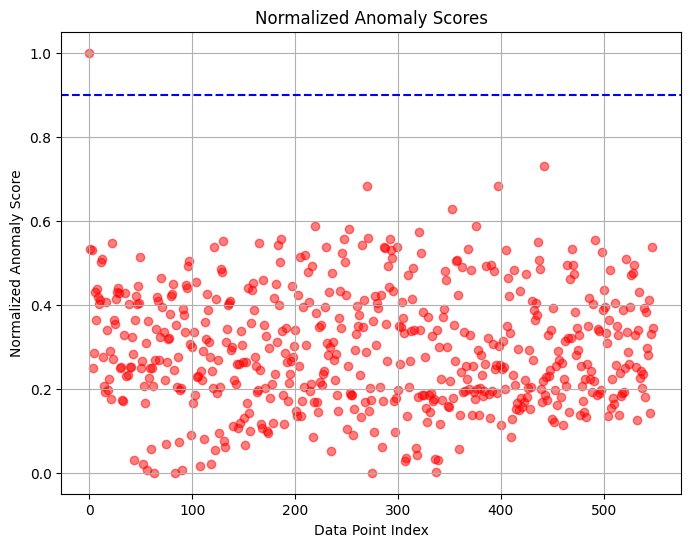

In [13]:
threshold = 0.1 # change of threshold
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

Anomalous data point correctly identified

### KNN

In [14]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.knn()

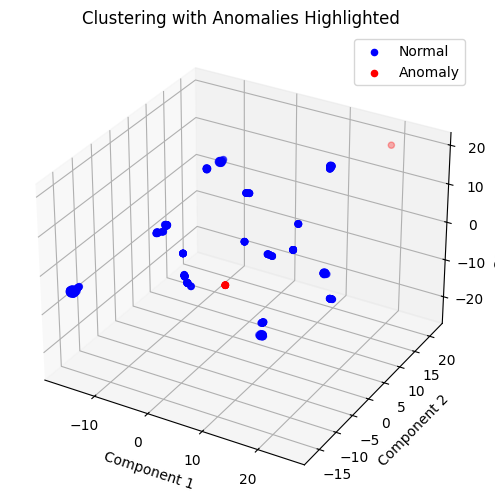

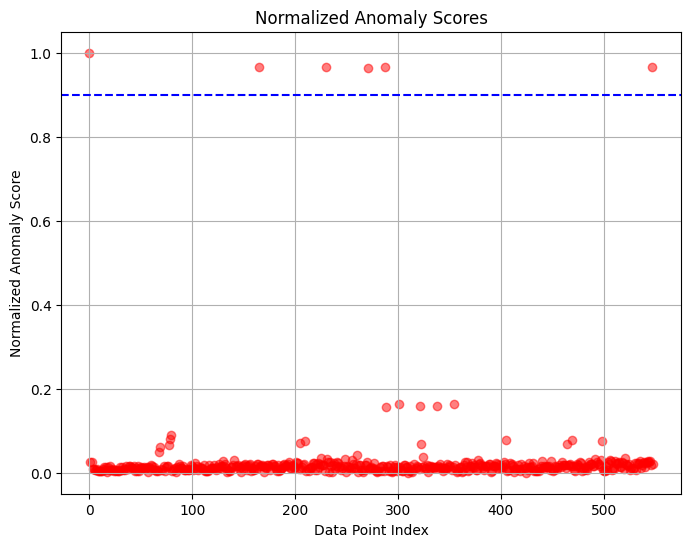

In [15]:
threshold = 10 # change of threshold
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

### LOF

In [16]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.lof()

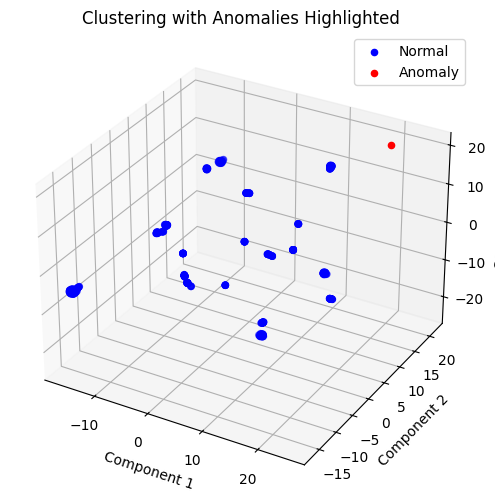

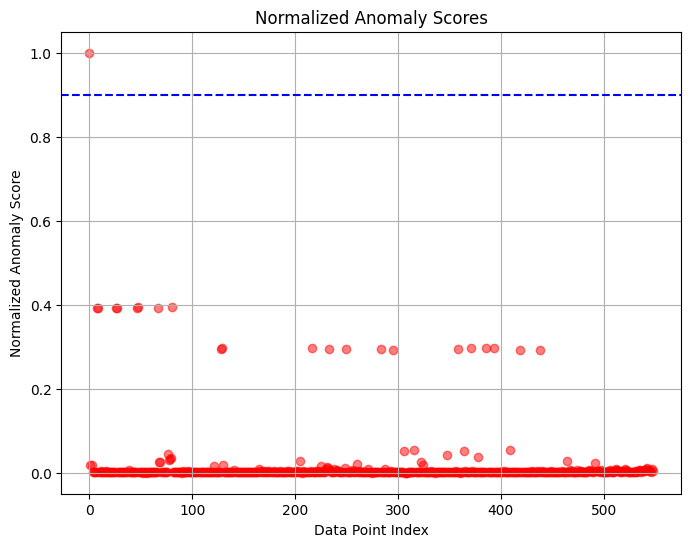

In [17]:
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

### others